In [1]:
#! pip install --no-build-isolation fa2
! pip install powerlaw
! pip install GitPython
! pip install wordcloud


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00


In [2]:
import os.path
import requests as req
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re as re

import networkx as nx
import json

#from fa2 import ForceAtlas2
import powerlaw

from nltk import word_tokenize
import string
import git

import nltk
nltk.download('punkt')


from scipy.stats import norm
import math

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# FUNCTIONS

In [3]:
# Count occurencies of elements in a list; return a dictionary
def occurencies(list):
    occurencies = {}
    for i in list:
        occurencies[i] = occurencies.get(i, 0) + 1
    return occurencies  # dictioanry key: value = element: occurencies

In [4]:
### Function explained in exercises below !! Reading could be skipped here

# load LabMt data from git directory
repository_url_score = "https://github.com/Davide011/Social_Graph"
# Clone the Git repository to a temporary directory
repo = git.Repo.clone_from(repository_url_score,"temp_directory")
# stored LabMT data from git
file_path_score = "temp_directory/Data_Set_S1.txt"
#file_path_score=r"C:\Users\david\Desktop\CORSI ORAAA\SOCIAL-GRAPH\W8\Data_Set_S1.txt" # load from pc


def remove_punctuation_lower(tokens):

    # Define a string containing all punctuation characters
    punctuation_chars = string.punctuation +"'' ``"

    # Remove all punctuation characters from the list of tokens
    tokens_without_punctuation = [token.lower()  for token in tokens if token not in punctuation_chars]
    return tokens_without_punctuation

#Function to compute the sentiment score  based on LabMT word scores


#  Load LabMT scores from a file into a dictionary
def load_labmt_scores_FILE(filename , lines_to_skip=4 ):
    labmt_scores = {}
    with open(filename, 'r', encoding='utf-8' ) as file:
        for _ in range(lines_to_skip):  # skip the first 4 lines(title, header, etc.)
            next(file)
        for line in file:
            liness= line.strip().split() # split the line into a list of strings
            #extract  0: word, 2: happiness_average
            word, score = liness[0], liness[2]
            labmt_scores[word] = float(score)  # add the word and its score to the dictionary
    return labmt_scores   # return the dictionary

# Load LabMT scores from a file into a dictionary (used in the function below)
sentiment_dict= load_labmt_scores_FILE(file_path_score)

# compute sentiment score of a text
def compute_sentiment(tokens, dictionary_sentiment_scores=sentiment_dict):
        """
        Compute the sentiment score of a text based on LabMT word scores.
        All tokens has to be already formatted (lower case, no punctuation, etc.)
        """
        #clean the tokens from punctuation and set to lowercase (use the function defined above)
        tokens= remove_punctuation_lower(tokens)
        score = 0                        # initialize the score to 0
        token_len=len(tokens)
        for token in tokens:                                  # select each token in the text
                if token not in dictionary_sentiment_scores:  # if the token is not in the dictionary, skip it
                        token_len-=1             # and don't count it in the average
                else:
                        score += dictionary_sentiment_scores[token] # add the score of the token to the total score
        return score/token_len   # return the average score for the list of tokens

# function used to count the number of words in te text
def count_words_NLTK(wikitext):
    # without nltk  regular expressions are used :
    #words_pattern = r'\b\w+\b'
    #words = re.findall(words_pattern, wikitext)

    # with nltk
    words=word_tokenize(wikitext)           # WITH nltk
    words= remove_punctuation_lower(words)  # set to lowercase, remove punctuation
    return len(words), words      # return the number of words and the list of words/tokens

# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2021/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment.

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday October the 31st, 2021 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/


(If you haven't set up an account on peergrade yet, go to www.peergrade.io/join and type in the class code: ***DPZEV6***.)

### Overview

This year's Assignment 2 is all about analyzing the network of rappers.

Note that this time I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaningfully answer.

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----

# ***Important!!! to be changed!***

If some issues occur in running the code, figures could be seen [here](https://nbviewer.org/github/Davide011/Social_Graph/blob/main/Assignment1_colab.ipynb) .

# Part 0: Building the network

To create our network, we downloaded the rapper Wiki pages from each coast (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions.

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.
> * Show the regular expressions you have built and explain in details how they work.

## Load Rappers data

The exercise starts with loading the rappers data from github respectively from East Coast and Weast Coast.
Two txt files are read using pandas.To each dataframe a column of Bool is added to retain Coast information after merging the 2 dataframe in the following step. Finally we get one complete dataset of all the rappers without loasing any information.

In [5]:
# Load Rapper lists  (East-West Coast Rappers) from Github
WestCost = pd.read_csv(r"https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2023/main/files/WestCoastRappers.csv")
EastCost = pd.read_csv(r"https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2023/main/files/EastCoastRappers.csv")

# ADD COLUMN OF BOOL TO final DATAFRAME to distinguish between East and West Coast rappers
# # crete a vector of ZEROs= False= West ;   ONEs= True = East
null_0 , ones_1 = np.zeros((len(WestCost) ), dtype=bool) , np.ones((len(EastCost)) , dtype=bool )
WestCost["Bool"] = null_0  # add a column of zeros to Weast Dataframe
EastCost["Bool"] = ones_1  # add a column of ones to East Dataframe

# CONCATENATE THE 2 DATAFRAME
data_all = pd.concat([WestCost, EastCost], axis=0)  # concat the 2 dataframe by rows (5 +5 rows = 10 rows)
data_all.reset_index(inplace=True)  # reset index
#data_all  # print the dataframe to ceck the result

## Create the Graph (Nodes and Edges)
* For each Rapper a Node is created
* Hyperlinks to other Rappers Wikipages are extracted from each Wikipage text ; each rapper connection is saved as a Graph edges.

**To optimize computations a Graph with attribute : "Coast", "Length_of_the_content" and "Sentiment" is created from beginning.Step-wise code explanations is present in respectively sections**

 Functions used to download the wikipedia page of a rapper and extract the links to other wikipedia pages :

In [6]:
# Functions used to download the wikipedia page of a rapper and extract the links to other wikipedia pages

# extract links from wikipedia page thanks to regular expression
def extract_links(wikitext):
    link_path = r"\[\[(.*?)\]\]"
    links= re.findall(link_path,wikitext)
    return links

# clean links from wikipedia page thanks to regular expression
def clean_links(links, pattern=r"([\s\w\d\(\)-]*)" ):
    links_1=[]
    for i in links:
        links_1.append(re.findall( pattern, i )[0] ) # [] is a patter, * is that search for this pattern 0 or more times
    return links_1

# combination of the 2 functions above( extract_links and clean_links)
def extract_clean (wikitext):
    links = extract_links(wikitext)
    links_1 = clean_links(links)
    #print("Check all links taken :", len(links_1) == len(links) )
    return links_1
    # it returns a list of stings (=LINKS that refer to other wikipedia pages)


### FUNCTION TO DOWNLOAD WIKIPEDIA PAGES and EXTRACT cleaned LINKS;
# in addition : count the words in the page and return a list of all words


def   download_wiki_NEW_sentiment( rapper_name ):
    params_ = {
            "action":"query",
            "prop":"revisions",
            "rvprop":"content",
            "format":"json",
            "titles": rapper_name
                }

    # download pages from wikipedia
    baseurl = "https://en.wikipedia.org/w/api.php?"    #wikipedia api
    wikitext_fun = req.get(baseurl, params=params_ )  # download the chosen page(=title)
    wikijson = wikitext_fun.json()  # convert the page in json format
    page_id = str(list( wikijson["query"]["pages"].keys())[0]) # extract Wiki page id
    # list of links to other wikipedia pages (not cleaned)
    wiki_links= wikijson["query"]["pages"][page_id]["revisions"][0]["*"]

    list_of_cleane_Links=  extract_clean(wiki_links) # extract and clean links from wikipedia page
    # 2 regx are been used in the function extract_clean!!

    count , l = count_words_NLTK(wiki_links)  # count= count words, l = list all words

    #output: list of stings(=LINKS to other wikipedia pages); count= count words, l = list all words
    return list_of_cleane_Links , count ,l

### Graph creation:


In [76]:
# Create a graph with the data of the rappers, Attributes: Coast, Length of the content, Sentiment score
def create_Wiki_graph_countWords_NEW_sentiment(data_all):
    g = nx.DiGraph()  # nx graph intialization
    print("Number of nodes in (data) :", len(data_all), "\n") # print number of nodes in the data

    for i in range(len(data_all)):
    # Find connected wikipedia pages; count = word count ; tokens = list of tokenized words in the page
        connected_links_list , count , tokens = download_wiki_NEW_sentiment( str(data_all.loc[i]["WikipediaPageName"]) )

        if len(tokens) == 0:  # if the page is empty, set the sentiment score to 0
             s_score = 0
        else:
            s_score = compute_sentiment(tokens)   # compute sentiment score of the page

       # add node to the graph with attributes: Coast, Length of the content, Sentiment score
        if data_all.loc[i][ "Bool"] == False: # extract infomation from bool column in the dataframe
            attribute_W = "West"               # set attribute to West
            g.add_node(data_all.loc[i]["WikipediaPageName"], Coast =attribute_W , length_of_the_content= count, Sentiment_score = s_score)
        else:
            attribute_E = "East"            # set attribute to East if the bool column of the selected rapper is True
            g.add_node(data_all.loc[i]["WikipediaPageName"], Coast = attribute_E , length_of_the_content= count, Sentiment_score=s_score )

        # add edges to the graph
        for link in connected_links_list:
            # add edge only if the link is in the list of rappers
            if link in data_all["WikipediaPageName"].values:
                g.add_edge(data_all.loc[i]["WikipediaPageName"], link)

    # print number of nodes in the output graph
    print("Number of nodes in output (graph) :", g.number_of_nodes(), "The change of the number is due to duplicate rappers in the data!","\n")
    return g




In [77]:
G_complete = create_Wiki_graph_countWords_NEW_sentiment(data_all)

Number of nodes in (data) : 801 

Number of nodes in output (graph) : 798 The change of the number is due to duplicate rappers in the data! 



Clean the Graph from nodes with in-degree=0 and out-degree=0 (isolated nodes) :

In [78]:
# put in a list all nodes with in_degree = 0 and out_degree = 0
to_be_removed_TOTAL_NEW = [x   for x in G_complete.nodes()  if G_complete.out_degree(x) == 0 and G_complete.in_degree(x) == 0 ]
G_cleaned = G_complete.copy()  # copy to not affect our original graph
G_cleaned.remove_nodes_from(to_be_removed_TOTAL_NEW)

Extract the weakly connected components of the graph (the largest connected component if the network were undirected) and create a subgraph :

In [10]:
# EXTRACT LARGE COMPONENT ()
communities_NEW = nx.weakly_connected_components(G_cleaned)  # extract communities

# extract the largest component =  node_groups[0] = list of nodes in the largest component
node_groups = []
for com in communities_NEW:
  node_groups.append(list(com))

# create a new graph with only the largest component
G = G_cleaned.subgraph(node_groups[0])  # extract the largest component


**From now the only graph is going to be used is the subgraph G (largest component).**

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.

The startegy that was used is based on the following steps:
1) Downloading the Wikipedia page of rappers iteratively in a for cicle.
2) Extract the links from the Wikipedia page to connected wikipedia pages:
* This was  done firstly by extract all the link infomations present in the wikijson file of the page:
$"wikijson["query"]["pages"][page_id]["revisions"][0]["*"]"$

This script is needed to explore thw Wiki API response to the exact position where hyperlink to connected Wikipedia pages are stored.To pay attention that all the keys beside the *page_id* present in the script are fixed for each Wiki API.(An exploratory of API response through nested Dictionaries  was needed to be done to come out with the script.)

*After gettina the text containing all the hyperlinks, an **"extraction and cleaning"** process for each hyperlink was done thanks to regular expressions.
  More precisely extraction was needed to find and extract only the links: text paked inside square brakets; the cleaning process assured to take only the relevat part of the hyperlink.

> * Show the regular expressions you have built and explain in details how they work.


For the **Extraction** and **Cleaning** process two different regular expression were used respectively in the *extract_links* and the *clean_links* function.

 1) The **extraction** of the hyperlink was performed by taking a raw text and extracting all the characters inside of four square brakets "[[]]".
    This operation was performed thanks to the re.findall() function that extract from the input wikitext all the tokens that fits with the fitted regular expression (link_path in our function).

    The link path regular expression r"\ [\ [(.*?)\ ]\ ]" do the following:

    * Firstly, "\ [\ [ ",match the pattern of two square brakets( \ was needed as square brakets otherwise has a specific action in regex expressions)*
    * Secondly, the midlle of the regex , "(.*?)" , is able to capture and extract a group that match the inside of the parenthesis.
    the " .*?", is a non-greedy capturing that mathc all the characters thanks to "." .In addition the "*"  means that the previous "."  will be mathced 0 or more times.  does it as few times as possible due to the non-greedy qualifier "?".
    * Finally, as at the first point ,"\ ]\ ]" match two final parenthesis.

    *In few words, the **extraction regex** is able  to match text that is enclosed within double square brackets (e.g., [[some text]]).*





2) The **Cleaning** of the extracted hyperlink is needed to extract only the meaningful part of the link (the first text before the "|" sible if present; it divede the hyperlink name to further not needed explanatory words).

    For this operation the following regular expression was used: *"([\s\w\d\ (\ )-]*)"* .
    * In this case as before the first and last parentesis "(  )" enable the group extraction.
    * In this case the square brakets "[ ]" are used as a character class, it means that inside them different regular expressions are placed, and the class willl be able to match with all of the inside expressions.

    More precisely:
    * "\s" matches with  any whitespace character, such as spaces and tabs.
    * "\w" matches any word character,
    * "\d" matches any digit (0,9);
    * "\ (" and "\ )" matches opening and closing parentheses respectively.

    In addition, "*" as before is a character class that indicates that the gorup before could be matched 0 or more times.



Below the regular expressions could be visualized inside the respectively functions:

In [11]:
def extract_links(wikitext):
    link_path = r"\[\[(.*?)\]\]"
    links= re.findall(link_path,wikitext)
    return links

# clean links from wikipedia page thanks to regular expression
def clean_links(links, pattern=r"([\s\w\d\(\)-]*)" ):
    links_1=[]
    for i in links:
        links_1.append(re.findall( pattern, i )[0] ) # [] is a patter, * is that search for this pattern 0 or more times
    return links_1

# Part 1: Network visualization and basic stats

Visualize your network of rappers (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you have already generated the network and extracted the largest weakly connected component (the "largest weakly connected component" of a directed network is the subgraph consisting of the nodes that would constitute the largest connected component if the network were undirected) . The visualization and statistics should be done for the largest weakly connected component only.

_Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

> * What is the number of nodes in the network?
> * What is the number of links?
> * Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?
> * Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)?
> * Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?
> * Plot the in- and out-degree distributions for the whole network.
>   * Use axes that make sense for visualizing this particular distribution.
>   * What do you observe?
>   * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?
> * Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?
> * Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (directed) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
>   * Whatever else you feel like that would make the visualization nicer.
> * Describe the structure you observe. What useful information can you decipher from this?

# TO BE DONE ES!
> * Who are the top 5 most connected **east-coast** rappers (again in terms of in/out-degree)?
> * Who are the top 5 most connected **west-coast** rappers (again in terms of in/out-degree)?

_Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

> * What is the number of nodes in the network?
> * What is the number of links?
> * Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?
> * Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)?
> * Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?
> * Plot the in- and out-degree distributions for the whole network.
>   * Use axes that make sense for visualizing this particular distribution.
>   * What do you observe?
>   * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?
> * Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?
> * Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.

In [12]:
def get_top_five_connected_rappers(G, coast, degrees):
  result = [];
  i = 0
  sorted_degrees = sorted(dict(degrees).items(), key=itemgetter(1), reverse=True)
  for degree in sorted_degrees:
    if G.nodes[degree[0]]["Coast"] == coast:
      result.append(degree)
      i = i + 1
      if i == 5:
        return result



In [125]:
from operator import itemgetter

print("The number of nodes in the network is: " + str(len(G.nodes)))
print("The number of links in the network is: " + str(len(G.edges)))

highest_out_degree = max(dict(G.out_degree()).items(), key = lambda x : x[1])
highest_in_degree = max(dict(G.in_degree()).items(), key = lambda x : x[1])

print("The node with the highest output degree in the network is " + str(highest_out_degree[0]) + " with " + str(highest_out_degree[1]) + " output links.")
print("The node with the highest input degree in the network is " + str(highest_in_degree[0]) + " with " + str(highest_in_degree[1]) + " input links.")

five_highest_out_degree = dict(sorted(dict(G.out_degree()).items(), key=itemgetter(1), reverse=True)[:5])
five_highest_in_degree = dict(sorted(dict(G.in_degree()).items(), key=itemgetter(1), reverse=True)[:5])

print("")
print("The top 5 nodes with the highest output degree are: ")
for node in five_highest_out_degree.items():
  print(node[0] + " with " + str(node[1]) + "out_degrees.")

print("")

print("The top 5 nodes with the highest input degree are: ")
for node in five_highest_in_degree.items():
  print(node[0] + " with " + str(node[1]) + " in_degrees.")

east_top_five_in_connected_rappers = get_top_five_connected_rappers(G, "East", G.in_degree())
east_top_five_out_connected_rappers = get_top_five_connected_rappers(G, "East", G.out_degree())

west_top_five_in_connected_rappers = get_top_five_connected_rappers(G, "West", G.in_degree())
west_top_five_out_connected_rappers = get_top_five_connected_rappers(G, "West", G.out_degree())

print(east_top_five_in_connected_rappers)
print(G.nodes["Snoop Dogg"]["Coast"])
out_degrees = list(dict(G.out_degree()).values())
in_degrees = list(dict(G.in_degree()).values())


The number of nodes in the network is: 724
The number of links in the network is: 5411
The node with the highest output degree in the network is Drag-On with 46 output links.
The node with the highest input degree in the network is Snoop Dogg with 126 input links.

The top 5 nodes with the highest output degree are: 
Drag-On with 46out_degrees.
Black Thought with 41out_degrees.
Dr. Dre with 36out_degrees.
Kendrick Lamar with 35out_degrees.
DJ Dahi with 35out_degrees.

The top 5 nodes with the highest input degree are: 
Snoop Dogg with 126 in_degrees.
Jay-Z with 115 in_degrees.
Nas with 99 in_degrees.
50 Cent with 93 in_degrees.
Busta Rhymes with 83 in_degrees.
[('Snoop Dogg', 126), ('Kendrick Lamar', 75), ('Tupac Shakur', 70), ('E-40', 63), ('The Game (rapper)', 56)]
East


It is interesting to see that there is no rappers that are both in the top 5 of in_degree and out_degree list.
It means that the rappers which connect with more other rappers are not the same which are more linked from other rappers.

Max in degree 126 
 Max out degree 46


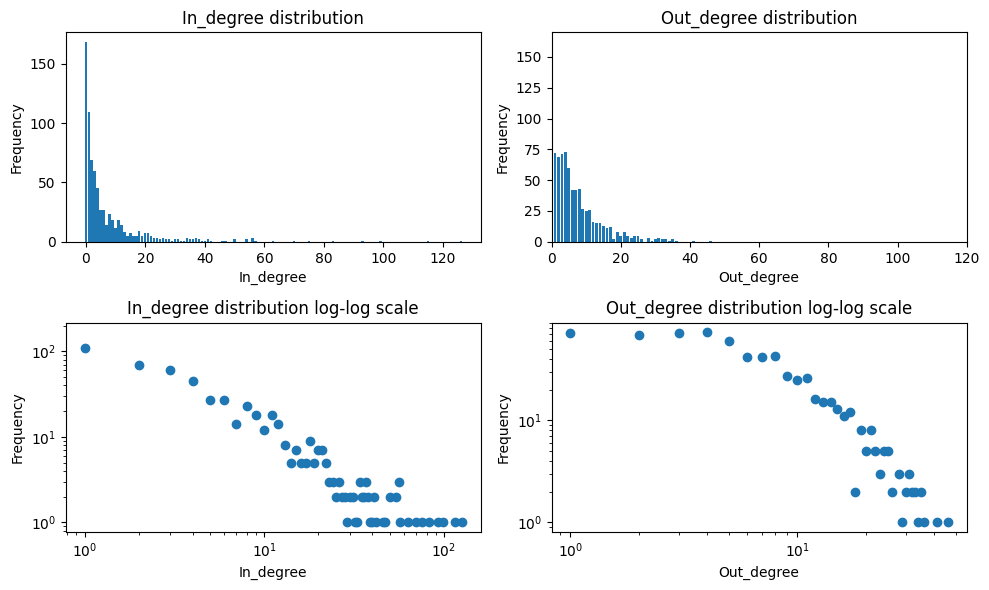

In [124]:
# TO  plot the distribution of in_degree and out_degree

plot_in_dict =  occurencies(in_degrees)  #dictionary degree : cout
plot_out_dict = occurencies(out_degrees)

k_in = plot_in_dict.keys() # extract degrees
k_out = plot_out_dict.keys()

freq_in = plot_in_dict.values() # extract the count
freq_out = plot_out_dict.values()

#sublots

print("Max in degree", max(k_in), "\n","Max out degree", max(k_out))
fig, axs = plt.subplots(2, 2, figsize=(10, 6) )

axs[0, 0].bar(k_in, freq_in)
axs[0, 0].set_title('In_degree distribution')
axs[0, 0].set_xlabel("In_degree")
axs[0, 0].set_ylabel("Frequency")

axs[0, 1].bar(k_out, freq_out)
axs[0, 1].set_title('Out_degree distribution')
axs[0, 1].set_xlabel("Out_degree")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].set_ylim(0, 170)


axs[0, 1].set_xlim(0, 120)

axs[1, 0].plot(k_in, freq_in,"o")
axs[1, 0].set_title('In_degree distribution log-log scale')
axs[1, 0].set_xlabel("In_degree")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].set_xscale("log")
axs[1, 0].set_yscale("log")

axs[1, 1].plot(k_out, freq_out,"o")
axs[1, 1].set_title('Out_degree distribution log-log scale')
axs[1, 1].set_xlabel("Out_degree")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].set_xscale("log")
axs[1, 1].set_yscale("log")

plt.tight_layout()
plt.show()

**Figure A1.1** <br>

The  main difference between the in-degree and the out-degree distibution is in the range.
In fact, the in degree distibution iis characterized by a huge number  of node with a low (less then 5) in-degree and a few outliers node with an exceptionally high in-degree (max in degree~120).
In opposition, the out degree distibution  has no exceptional outliers (max out degree ~40), in addition the distibution appear to be smoother also in the range of the low degree (less then 5).
In addition from the log-log scale plot it could be seen that the in_degree distibution appears linear, that means that the original in_degree distibution has a even  more prominent  power law relationship than the out_degree.

**From a pedagocical point of view** this difference could be explained by the meaning of the in and out degrees. In fact, in_degrees refer to the number of links that connect to the certaine node. Often happens that some ,fewer people/artists have qualities that attract other individuals (i.e a rapper that start a new stile) that makes the in_degree be extremly high for few personalities and exteamly lower for the most.

By contrast, the out_degree shows the number of out connections that a certaine node has (i.e artistical relationship of a rapper  with other rappers). In this case is more common that people/artists has a more stable range of connections.
In fact most of the artist has some other artist from that take inspiration. This also explain the firts in_degree distibution , where most of nodes has at least a few out_degree and almost connected to the same nodes.

> **Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.**

From the exercise it was interpreted that:

>     * Compare the degree distribution to a *random network* with the same number of nodes and *p*
>     * Compare the degree distribution to a *scale-free* network with the same number of nodes.

Startig from :

$〈k〉 = p(N-1) $

we could find p:

$p = \frac{\langle k \rangle}{N-1} $

In [142]:
#random
# find average degree of the network g
degree_list_all = list(dict(G.degree()).values())
avg_deg = np.mean(degree_list_all)   # average degree <k>
print("Average degree :", avg_deg)
N_nodes_G = int(len(G.nodes()))
p= avg_deg / N_nodes_G
print("p :", p)

# random graph

G_random =  nx.erdos_renyi_graph( N_nodes_G, p)
degree_list_random = list(dict(G_random.degree()).values())
plot_random =  occurencies(degree_list_random)  #dictionary degree : cout
k_random = plot_random.keys() # extract degrees
freq_random = plot_random.values()  # all degree

# scale free

G_scale_free = nx.barabasi_albert_graph(N_nodes_G, int(avg_deg/2) )
degree_list_scale_free = list(dict(G_scale_free.degree()).values())
plot_scale_free =  occurencies(degree_list_scale_free)  #dictionary degree : cout
k_scale_free = plot_scale_free.keys() # extract degrees
freq_scale_free = plot_scale_free.values()  # all

# all network
degree_list_all = list(dict(G.degree()).values())
plot_all = occurencies(degree_list_all) # all degree
k_all = plot_all.keys()  # all degree
freq_all = plot_all.values()  # all degree

Average degree : 14.947513812154696
p : 0.020645737309605935


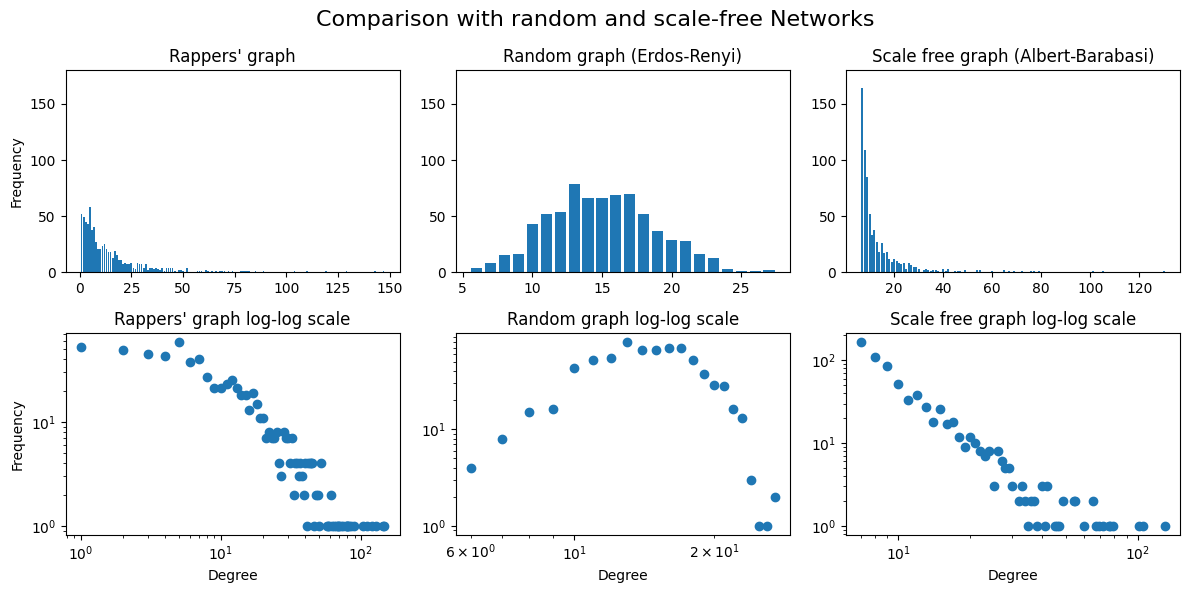

In [147]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6) )
plt.suptitle( "Comparison with random and scale-free Networks", fontsize=16 )

axs[0, 0].bar(k_all, freq_all)
axs[0, 0].set_title('Rappers\' graph')
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].set_ylim(0, 180)
axs[0, 1].set_ylim(0, 180)
axs[0, 2].set_ylim(0, 180)

axs[0, 1].bar(k_random, freq_random)
axs[0, 1].set_title('Random graph (Erdos-Renyi)')

axs[0, 2].bar(k_scale_free, freq_scale_free)
axs[0, 2].set_title('Scale free graph (Albert-Barabasi)')

axs[1, 0].plot(k_all, freq_all,"o")
axs[1, 0].set_title('Rappers\' graph log-log scale')
axs[1, 0].set_xscale("log")
axs[1, 0].set_yscale("log")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].set_xlabel("Degree")

axs[1, 1].plot(k_random, freq_random,"o")
axs[1, 1].set_title('Random graph log-log scale')
axs[1, 1].set_xscale("log")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("Degree")


axs[1, 2].plot(k_scale_free, freq_scale_free,"o")
axs[1, 2].set_title('Scale free graph log-log scale')
axs[1, 2].set_xscale("log")
axs[1, 2].set_yscale("log")
axs[1, 2].set_xlabel("Degree")
plt.tight_layout()

plt.show()

**Figure A1.2**

In the figure above the comparison between our Rappers' Graph with the artificial generated Erdos-Renyi random graph and the scale free Albert_Barabasi graph. It could be seen from the log-log plots that the both the Rappers' and the Barbasi Networks follow a power law distibution, which tipically exhibit the small-world property. By contrast, the random graph appears to have a poisson like distibution.


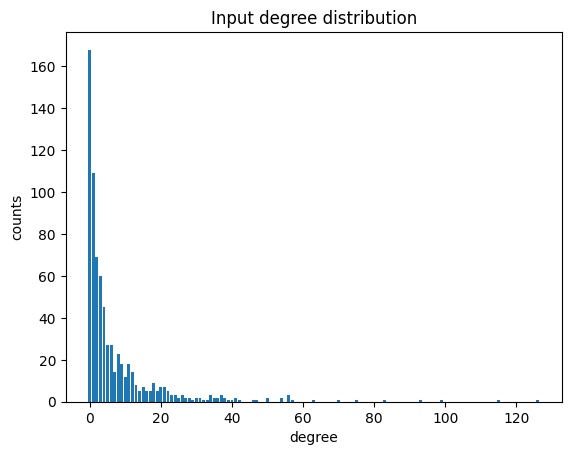

In [15]:
plot_degree_distribution(in_degrees, "Input degree distribution")

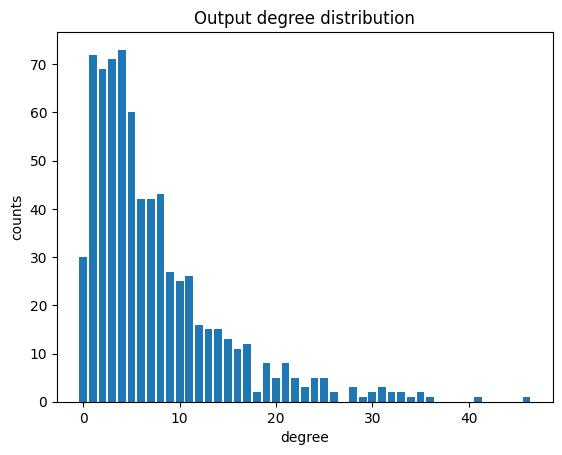

In [14]:
def plot_degree_distribution(degrees, title):
  #Calculate the bin edges so that the integers fall in the middle
  bin_edge_list = [i-0.5 for i in range(min(degrees), max(degrees)+2)]
  counts, bin_edges = np.histogram(degrees, bin_edge_list)
  #We use the bin centres again for the plot so bars align with xticks
  plt.bar(list(range(min(degrees), max(degrees)+1)), counts)
  plt.xlabel('degree')
  plt.ylabel('counts')
  plt.title(title)
  plt.show()

plot_degree_distribution(out_degrees, "Output degree distribution")

In [16]:
in_degrees_exponent = powerlaw.Fit(in_degrees).alpha
out_degrees_exponent = powerlaw.Fit(out_degrees).alpha

print("The exponent of the powerlaw for the input degrees is: " + str(in_degrees_exponent))
print("The exponent of the powerlaw for the output degrees is: " + str(out_degrees_exponent))

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
The exponent of the powerlaw for the input degrees is: 2.7988741452095898
The exponent of the powerlaw for the output degrees is: 10.648183207966964


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


$\alpha$: Alpha is the exponent that characterizes the shape of the power-law distribution. It determines how quickly the tail of the distribution decays. A lower alpha value indicates a steeper, heavier-tailed distribution, while a higher alpha value indicates a shallower, lighter-tailed distribution.

If $\alpha$ is less than 1, it signifies a distribution with a very heavy tail, often referred to as a "fat-tailed" distribution. This suggests that there are rare but extremely large values in the data.
If $\alpha$ is between 1 and 2, it indicates a power-law distribution with a heavy tail, but not as extreme as when α is less than 1.
If $\alpha$ is greater than 2, it suggests a distribution with a lighter tail, resembling a more typical or "normal" distribution.

In our case both the in_degree and out_degree $\alpha$ have a alpha value greather than 2 , that means havening lighter tails as it could also be seen in the above in/out_degree distibution in **Figure A1.1**  <br> .

15


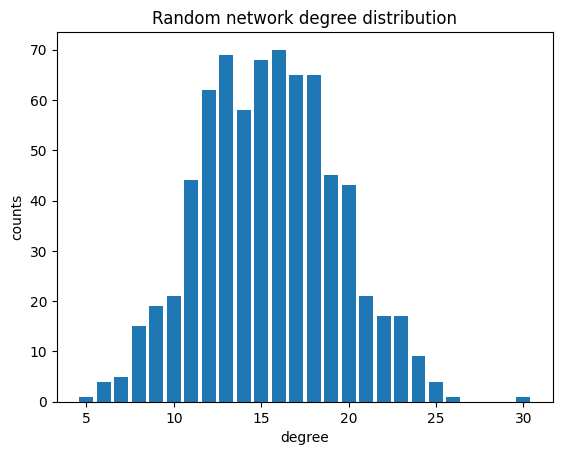

In [17]:
degrees = list(dict(G.degree()).values())
average_degree = round(sum(degrees)/len(degrees))
print(average_degree)

# With the average degree calculated, we can now know the probability of connection between two nodes to construct our random network.
# d = p * (724-1)
# p = d / (724-1)

p = average_degree/723

# Now we can construct our network and plot the degree distribution
random_G = nx.erdos_renyi_graph(724, p)
plot_degree_distribution(list(dict(random_G.degree()).values()), "Random network degree distribution")

**Figure A1.3** <br>

EXERCISE 1B

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (directed) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
>   * Whatever else you feel like that would make the visualization nicer.
> * Describe the structure you observe. What useful information can you decipher from this?

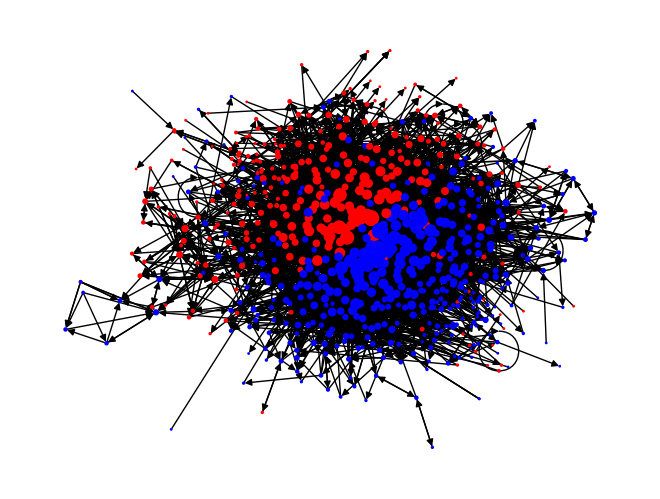

In [18]:
node_color_map = []
degree_map = list(dict(G.degree()).values())

nodes = G.nodes
for node_index in nodes:
    if nodes[node_index]["Coast"] == "East":
        node_color_map.append("red")
    else:
        node_color_map.append("blue")

nx.draw(G, pos=nx.kamada_kawai_layout(G), node_size=degree_map, node_color=node_color_map)

In [114]:
colors_3=[]
for u in G.nodes(data="Coast"):
    #print(u[1])
    if u[1] == "West":
        colors_3.append("blue")
        #print("red")
    else:
        colors_3.append("red")

#print("Nodes:",len(colors_3))

In [115]:
# node size
degree_map = list(dict(G.degree()).values())

In [116]:
edge_color_my = []
for u in G.edges(data="Coast"):

    b = nx.get_node_attributes(G, 'Coast')  #extract attibute for all nodes

    first_node = u[0]
    second_node = u[1]


    b["03 Greedo"]

    if b[first_node] == "West" and b[second_node] == "West":
        edge_color_my.append("blue")

    if b[first_node] == "East" and b[second_node] == "East":
        edge_color_my.append("red")

    if b[first_node] == "East" and b[second_node] == "West" or b[first_node] == "West" and b[second_node] == "East":
        edge_color_my.append("green")

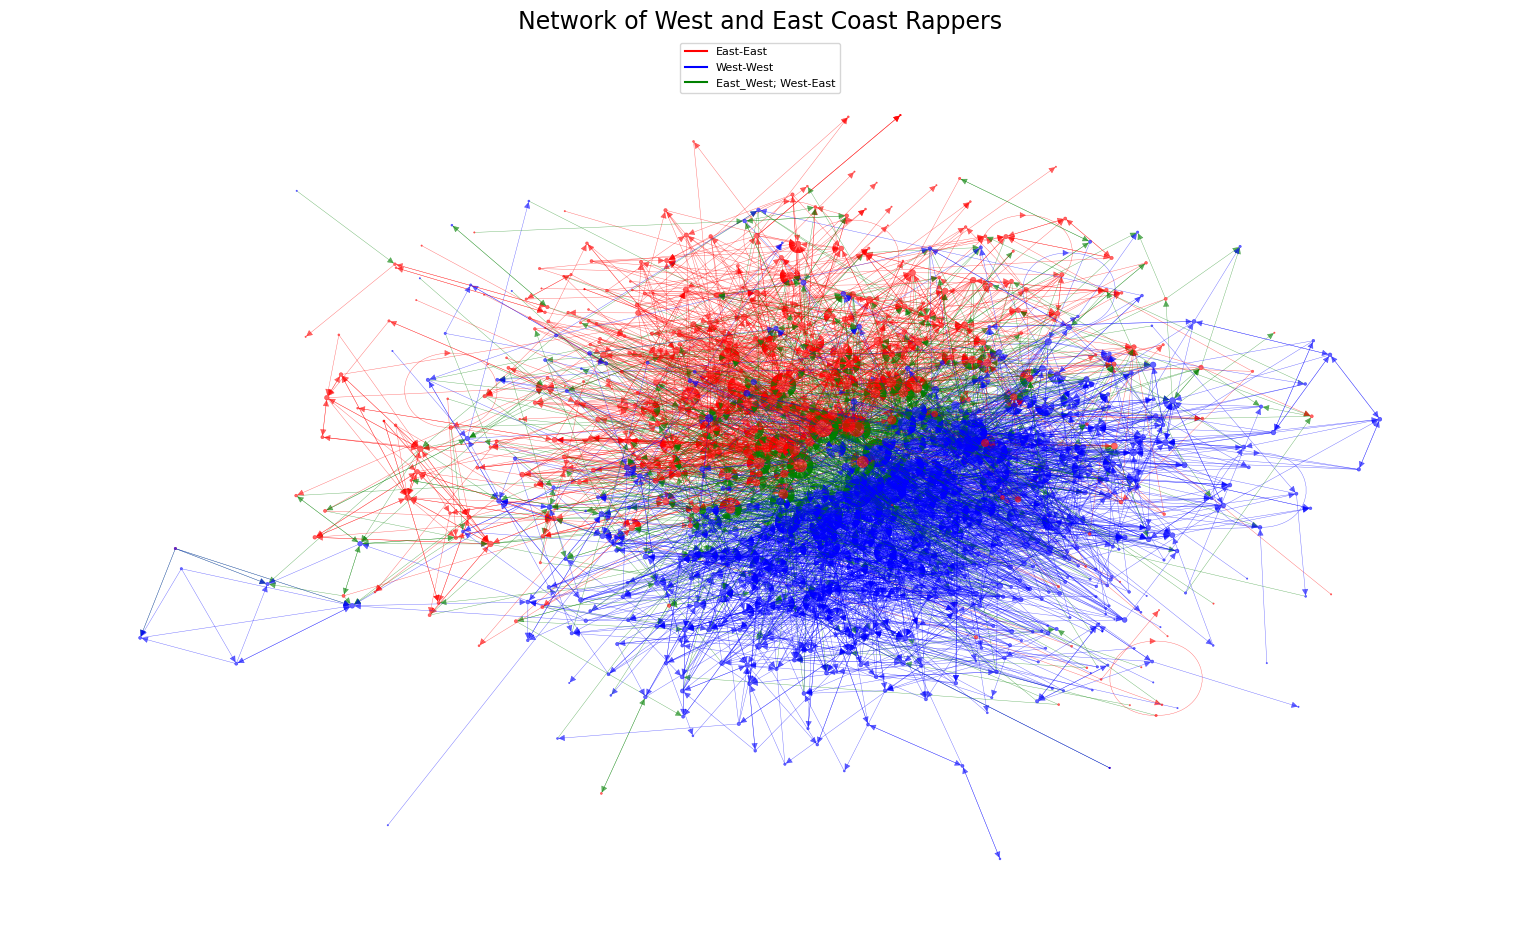

In [119]:
plt.figure(figsize=(15,9));

nx.draw_kamada_kawai(G, with_labels=False, node_size= degree_map, node_color= colors_3, edge_color = edge_color_my, linewidths=0.4, alpha=0.6, width=0.3)

#plt.gca().collections[0].set_edgecolor("#000000")
plt.title("Network of West and East Coast Rappers", fontsize=17)



#Add legends, labels a
colors = {"East-East":"red", "West-West":"blue", "East_West; West-East":'green'}
labels = list(colors.keys())
handles = [plt.Line2D([0], [0], color=colors[label], linestyle='-' if label == "East-East" or "West-West" else '-') for label in labels]
plt.legend(handles, labels, fontsize=8,  loc='upper center')
plt.show()

**Figure B1.2** <br>

From the visual rapresenatation of the graph it could be seen that most of the connections happens between nodes of the same gorup (rappers of the same Coast;  red and blue connections). In addition it could be seen that fewer of the nodes of both the Coasts has the main number of connections with the opposite group, working as middle-men hubs between the groups. Last but not least, it could be noticed that the  Graph has more  West Coast nodes (blue) then East Coast (red) nodes.

# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from rappers' Wikipedia pages.

Here's what you need to do:
> * Create a word-cloud for each coast according to the novel TF-TR method. Feel free to make it as fancy as you like. Explain your process and comment on your results.
> * For each coast, what are the 5 words with the highest TR scores? Comment on your result.

In [93]:

# Tokenizes text using NLTK, deleting tokens that are punctuation symbols.
def tokenize_text(text):
  count , l = count_words_NLTK(text)
  return l


# Downloads a Wikipedia page and extracts the text.
def download_wiki_text( rapper_name ):
    params_ = {
            "action":"query",
            "prop":"extracts",
            "exlimit":"1",
            "explaintext": "1",
            "format":"json",
            "titles": rapper_name
                }

    # download pages from wikipedia
    baseurl = "https://en.wikipedia.org/w/api.php?"    #wikipedia api
    wikitext_fun = req.get(baseurl, params=params_ )  # download the chosen page(=title)
    wikijson = wikitext_fun.json()  # convert the page in json format
    page_id = str(list( wikijson["query"]["pages"].keys())[0]) # extract Wiki page id
    # list of links to other wikipedia pages (not cleaned)
    text = wikijson["query"]["pages"][page_id]["extract"]
    return text


# Download all wikipedia pages, tokenize its text, and return a dictionary of the occurencies of each word. Separated for east and west coast.
def create_token_dicts_for_west_and_east(data_all):
    west_coast_token_dict = {}
    east_coast_token_dict = {}

    for i in range(len(data_all)):
    # Find connected wikipedia pages; count = word count ; tokens = list of tokenized words in the page
        name = str(data_all.loc[i]["WikipediaPageName"])
        text = download_wiki_text( name )
        tokens = tokenize_text(text)

        if data_all.loc[i][ "Bool"] == False: # extract infomation from bool column in the dataframe
          for token in tokens:
            if token in west_coast_token_dict:
              west_coast_token_dict[token] = west_coast_token_dict[token] + 1
            else:
              west_coast_token_dict[token] = 1
        else:
            for token in tokens:
              if token in east_coast_token_dict:
                east_coast_token_dict[token] = east_coast_token_dict[token] + 1
              else:
                east_coast_token_dict[token] = 1

    return west_coast_token_dict, east_coast_token_dict

In [94]:
west_coast_token_dict, east_coast_token_dict = create_token_dicts_for_west_and_east(data_all)

In [95]:

# Creates a weights dictionary based on the number of ocurrences for each token in its own coast and in the contrary. Creates one dictionary for each west and east coast.
def create_weight_dictionaries(west_coast_token_dict, east_coast_token_dict):
  west_coast_weight_dict = {}
  east_coast_weight_dict = {}
  c = 1

  for token in west_coast_token_dict:
    west_count = west_coast_token_dict[token]

    if token in east_coast_token_dict:
      east_count = east_coast_token_dict[token]
    else:
      east_count = 0

    west_weight = (west_count/(east_count + c))
    east_weight = (east_count/(west_count + c))

    west_coast_weight_dict[token] = west_weight
    east_coast_weight_dict[token] = east_weight

  for token in east_coast_token_dict:
    if token in east_coast_weight_dict:
      continue;
    else:
      east_coast_weight_dict[token] = east_coast_token_dict[token]

  return west_coast_weight_dict, east_coast_weight_dict


In [96]:
from string import punctuation

# Removes stop words from the dictionary. Stop words are filler words that do not provide any significance.
def remove_stop_words(dictionary):

  stop_words = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz","cite","category"]

  for word in stop_words:
    if word in dictionary:
        del dictionary[word]

  return dictionary

# Removes tokens with special characters in them.
def remove_tokens_with_special_characters(dictionary):
  special_characters = punctuation
  for character in special_characters:
    for key, value in dictionary.copy().items():
      if character in key:
        del dictionary[key]
  return dictionary

# Removes all irrelevant tokens from the dictionary so we get the most meaning from our word cloud
def remove_irrelevant_tokens(dictionary):
  dictionary = remove_stop_words(dictionary)
  dictionary = remove_tokens_with_special_characters(dictionary)
  return dictionary


In [23]:
# In this step we remove the irrelevant tokens from the dictionaries. We do this to work with less data but most importantly to use words with meaning in our word clouds.

west_coast_token_dict_clean = remove_irrelevant_tokens(west_coast_token_dict)
east_coast_token_dict_clean = remove_irrelevant_tokens(east_coast_token_dict)

In [24]:
# In this step we transform the token dictionaries into weight dictionaries. We do this to assign a weight to each token so we can compute it correctly in the word cloud.

west_coast_weight_dict, east_coast_weight_dict = create_weight_dictionaries(west_coast_token_dict_clean, east_coast_token_dict_clean)


In [97]:
# Generates the string for the generation of the word cloud. The tokens are concatenated a certain number of times which is based in their weight.
def generate_word_cloud_string(word_dict):
  result = ""
  for key, value in word_dict.items():
    for i in range(int(value)):
      result = " ".join([result,key])

  return result


In [98]:
# In this step, we generate the strings for each coast needed to generate the word cloud.
west_word_cloud_string = generate_word_cloud_string(west_coast_weight_dict)
east_word_cloud_string = generate_word_cloud_string(east_coast_weight_dict)

In [99]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


# In this step we generate the word clouds using the WordCloud package.

wordcloud_west = WordCloud(collocations = False).generate(west_word_cloud_string)
wordcloud_east = WordCloud(collocations = False).generate(east_word_cloud_string)


The top 5 tokens with the highest TR score for the west coast are:
Token "okonma" with score 103.0
Token "broadus" with score 78.0
Token "tde" with score 65.0
Token "kgositsile" with score 65.0
Token "lars" with score 58.0


(-0.5, 399.5, 199.5, -0.5)

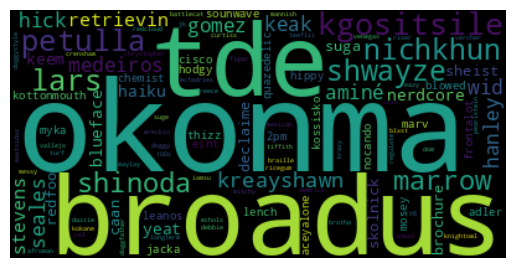

In [100]:
# Here we plot the word cloud for the West Coast

sorted_west_coast = sorted(west_coast_weight_dict.items(), key=lambda x:x[1], reverse=True)
print("The top 5 tokens with the highest TR score for the west coast are:")
for i in range(5):
  print("Token " + '"' + sorted_west_coast[i][0] + '" with score ' + str(sorted_west_coast[i][1]))

plt.imshow(wordcloud_west, interpolation='bilinear')
plt.axis("off")

The top 5 tokens with the highest TR score for the east coast are:
Token "hernandez" with score 144
Token "dumile" with score 94
Token "coke" with score 88
Token "jipsta" with score 80
Token "kirkland" with score 79


(-0.5, 399.5, 199.5, -0.5)

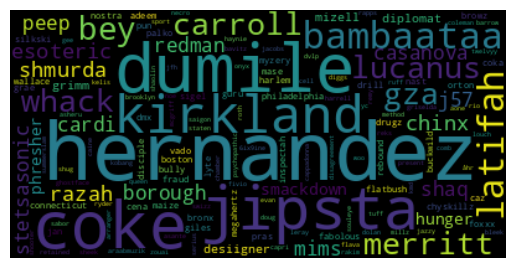

In [101]:
# Here we plot the word cloud for the East Coast

sorted_east_coast = sorted(east_coast_weight_dict.items(), key=lambda x:x[1], reverse=True)
print("The top 5 tokens with the highest TR score for the east coast are:")
for i in range(5):
  print("Token " + '"' + sorted_east_coast[i][0] + '" with score ' + str(sorted_east_coast[i][1]))

plt.imshow(wordcloud_east, interpolation='bilinear')
plt.axis("off")

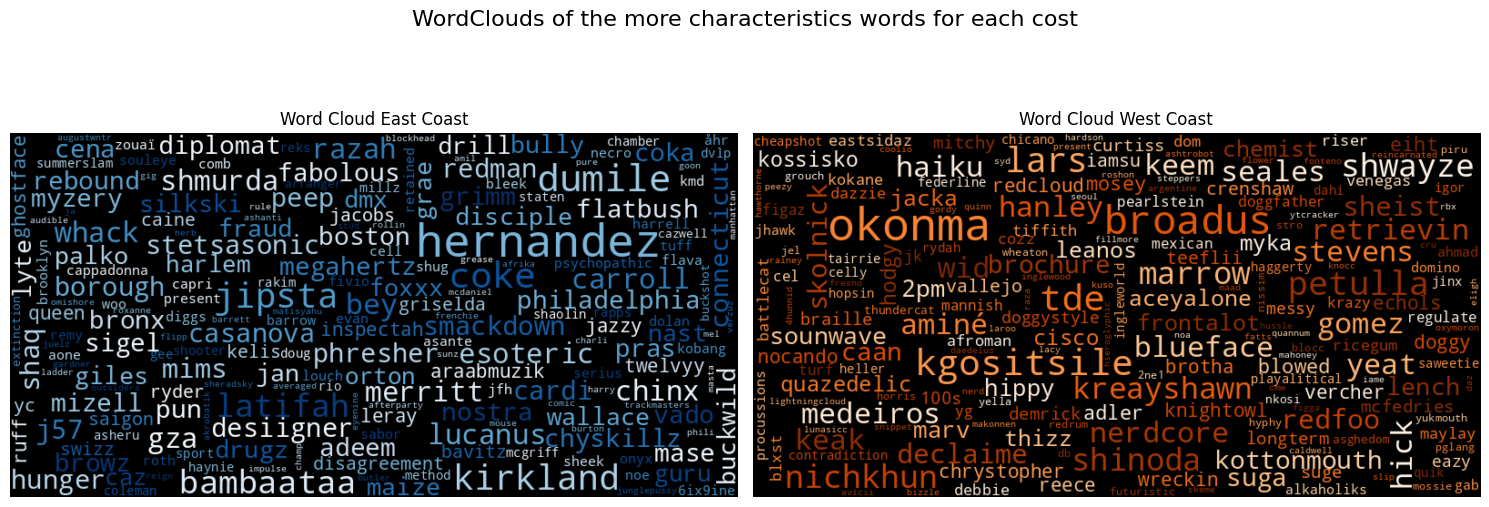

The top 5 tokens with the highest TR score for the west coast are:
Token "okonma" with score 103.0
Token "broadus" with score 78.0
Token "tde" with score 65.0
Token "kgositsile" with score 65.0
Token "lars" with score 58.0

The top 5 tokens with the highest TR score for the east coast are:
Token "hernandez" with score 144
Token "dumile" with score 94
Token "coke" with score 88
Token "jipsta" with score 80
Token "kirkland" with score 79


In [102]:
# subplot
# subplot
fig = plt.figure()
fig.set_size_inches(15, 6)  # size of the figure (the outside box)
fig.suptitle('WordClouds of the more characteristics words for each cost', fontsize=16)

wordcloud_west = WordCloud(width=800, height=400,max_font_size=50,  collocations = False, colormap='Oranges_r').generate(west_word_cloud_string)
wordcloud_east = WordCloud(width=800, height=400,max_font_size=50,  collocations = False, colormap='Blues_r').generate(east_word_cloud_string)
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_east, interpolation="bilinear" ,)
plt.title("Word Cloud East Coast")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_west, interpolation="bilinear")
plt.title("Word Cloud West Coast")
plt.axis("off")
plt.tight_layout(  )


plt.show()
# top west
sorted_west_coast = sorted(west_coast_weight_dict.items(), key=lambda x:x[1], reverse=True)
print("The top 5 tokens with the highest TR score for the west coast are:")
for i in range(5):
  print("Token " + '"' + sorted_west_coast[i][0] + '" with score ' + str(sorted_west_coast[i][1]))
print("")
# top 5
sorted_east_coast = sorted(east_coast_weight_dict.items(), key=lambda x:x[1], reverse=True)
print("The top 5 tokens with the highest TR score for the east coast are:")
for i in range(5):
  print("Token " + '"' + sorted_east_coast[i][0] + '" with score ' + str(sorted_east_coast[i][1]))

# Part 3: Communities

Find communities and their modularity (from lecture 7).

Here's what you need to do:
> * In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it.
> * Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?
> * Comment on your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.
> * Now, partition your rappers into two communities based on which coast they represent.
>   * What is the modularity of this partition? Comment on the result.

In [30]:
undir_G = G.to_undirected()  # set graph to undirected

> **3.1. In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it.**

Modularity evaluates if a group of nodes is better connected than it would be in a random graph, it's a score to evaluate how well a group of nodes form a community. The formula takes the fraction of edges of the graph that are in the community and subtracts the fraction of degrees that are in the community squared. So for the value to be positive, the degrees of the nodes in the partition can't be significantly higher than the average (2*L is the total degree in the graph), the higher this degree is compared to the total, the more edges that have to be in the partition. In very simple terms, most of the degrees of the nodes of the partition have to be dedicated to edges within the partition (connecting to other nodes in the community).

In [31]:
def modularity(G, node_list):
    L = G.number_of_edges()
    community_graph = G.subgraph(node_list)
    Lc = community_graph.number_of_edges()
    kc = sum([G.degree(rapper) for rapper in node_list if rapper in G])

    return (Lc / L) - (kc / (2*L))**2

> **3.2. Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?**


We used the louvain community algorithm on both coasts individually, this algorithm works as follows:  

    * 1. Each node is assigned its own community

    * 2. The modularity of all communities is calculated

    * 3. For each node, we calculate the change in modularity obtained by removing it from its current community and moving it to each of each of its neighboring nodes

    * 4. We keep each node in the community that yields the highest change in modularity and repeat the previous step until no more change can be obtained.

    * 5. when this is done, the resulting communities are converted to nodes in a new graph, where internal edges are self-loops and edges from one community to another turn into weighted links (according to total number of edges in between). The previous algorithm (1-4) is then run again.
>

In [32]:
from community import community_louvain
from collections import defaultdict

wc_nodes = [rapper for rapper in pd.read_csv(r"https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2023/main/files/WestCoastRappers.csv",index_col=0)['WikipediaPageName'] if rapper in undir_G]
ec_nodes = [rapper for rapper in pd.read_csv(r"https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2023/main/files/EastCoastRappers.csv",index_col=0)['WikipediaPageName'] if rapper in undir_G]

east_graph = undir_G.subgraph(ec_nodes)
west_graph = undir_G.subgraph(wc_nodes)
east_com = community_louvain.best_partition(east_graph)
west_com = community_louvain.best_partition(west_graph)
joint_communities = defaultdict(list)

for rapper, community in east_com.items():
    joint_communities[community].append(rapper)
num_communities = len(joint_communities.keys())

# Start the community number where the east left off so that we get unique identifiers
for rapper, community in west_com.items():
    joint_communities[num_communities+community].append(rapper)

print('Communities: ')
for community, rap_list in sorted(joint_communities.items(), key=lambda item: len(item[1]), reverse=True):
    print(f'\tid: {community}, size: {len(rap_list)}, modularity: {modularity(undir_G,rap_list):.4}, coast: {"East" if rap_list[0] in ec_nodes else "West"}')


Communities: 
	id: 0, size: 63, modularity: 0.04466, coast: East
	id: 26, size: 62, modularity: 0.04338, coast: East
	id: 3, size: 60, modularity: 0.03538, coast: East
	id: 31, size: 60, modularity: 0.03032, coast: East
	id: 29, size: 59, modularity: 0.03447, coast: East
	id: 6, size: 57, modularity: 0.02847, coast: East
	id: 2, size: 46, modularity: 0.0233, coast: East
	id: 37, size: 41, modularity: 0.02183, coast: East
	id: 27, size: 40, modularity: 0.01314, coast: East
	id: 12, size: 36, modularity: 0.01205, coast: East
	id: 32, size: 18, modularity: 0.004723, coast: East
	id: 10, size: 11, modularity: 0.003082, coast: East
	id: 5, size: 7, modularity: 0.001477, coast: East
	id: 8, size: 5, modularity: 0.0008539, coast: East
	id: 34, size: 5, modularity: 0.0008539, coast: East
	id: 9, size: 4, modularity: 0.0006384, coast: East
	id: 13, size: 4, modularity: 0.0008539, coast: East
	id: 35, size: 4, modularity: 0.0006384, coast: East
	id: 39, size: 4, modularity: 0.0008539, coast: Eas

> **3.3. Comment on your results**

I found around 50 communities, ranging from some with up to 70 components to many with a single one. The bigger ones generally have higher modularity, up to 0.05, while the smaller ones have lower values, only the ones with size 1 have negative modularities. We can see all these values above as well as the coast they belong to, interestingly the west coast is the one with the most communities of size 1, but apart from this the sizes seem pretty well balanced. Below we can see a histogram with the sizes of the communities, it's not very informational due to the small sample size and the big ammount of single element communities.

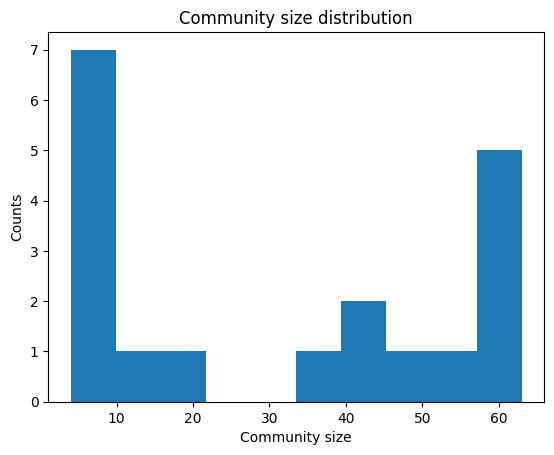

In [33]:
lengths = [len(rap_list) for rap_list in joint_communities.values() if len(rap_list)>1]
plt.hist(lengths, bins=10)
plt.title('Community size distribution')
plt.xlabel('Community size')
plt.ylabel('Counts')
plt.show()

**Figure 3.1** <br>
The community size distibution shows that there are two peaks respectively in the lower and the upper comunity size values. This means that the most frequent communities are the ones with size less then 10 nodes.



**3.4. Now, partition your rappers into two communities based on which coast they represent. What is the modularity of this partition? Comment on the result.**

In [34]:
print(f'Modularity of the east coast community: {modularity(undir_G,ec_nodes)}')
print(f'Modularity of the west coast community: {modularity(undir_G,wc_nodes)}')

Modularity of the east coast community: 0.12647518616810732
Modularity of the west coast community: 0.12647518616810732


We can see that both coasts have a similar modularity score, which shows that they do in fact represent communities with more dense connectivity than a random graph.

# Part 4: Sentiment of communities

Analyze the sentiment of communities (lecture 8). More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* Average the average sentiment of the nodes in each community to find a community-level sentiment.

Here's what you need to do (use the LabMT wordlist approach):
> * Calculate and store sentiment for every rapper
> * Create a histogram of all rappers' associated sentiments.
> * What are the 10 rappers with happiest and saddest pages?

Now, compute the sentiment of each coast:
> * Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).
> * Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.
> * Does the result make sense to you? Elaborate.

**Congratulations for making it to the end of the Assignment. Good luck with your independent project**



> ## es4 start









> * Calculate and store sentiment for every rapper

**To optimize the machine power,the sentiment score was alreadz calculated and stores as an attibute in the graph creation in es 0**

Following, all the used funcions and steps are explained.








In [35]:
# Load LabMt data from git directory
repository_url_score = "https://github.com/Davide011/Social_Graph"   # git hub directory were the data were previously stored
# Clone the Git repository to a temporary directory (Run before!)
#   repo = git.Repo.clone_from(repository_url_score,"temp_directory")
# colab directory were stored LabMT data
file_path_score = "temp_directory/Data_Set_S1.txt"

# if LabMT data loaded from stored directory in computer, use the folowing(your path)
#file_path_score=r"C:\Users\david\Desktop\CORSI ORAAA\SOCIAL-GRAPH\W8\Data_Set_S1.txt"

To calculate the sentiment score the followings function were created:

1) load LabMT scores in to a dictionary (word:score)

2) compute sentiment score

In [36]:
#  function to Load LabMT scores from a file into a dictionary
def load_labmt_scores_FILE(filename , lines_to_skip=4 ):
    labmt_scores = {}                         # initialize the dictionary
    with open(filename, 'r', encoding='utf-8' ) as file:   # open the file
        for _ in range(lines_to_skip):       # skip the first 4 lines(title, header, etc.)
            next(file)
        for line in file:
            liness= line.strip().split() # split the line into a list of strings
            #extract  0: word, 2: happiness_average
            word, score = liness[0], liness[2]
            labmt_scores[word] = float(score)  # add the word and its score to the dictionary
    return labmt_scores   # return the dictionary


Dictionary created : *sentiment_dict= load_labmt_scores_FILE(file_path_score)*


In [37]:
# Function to remove punctuation and set to lowercase used in the function below
def remove_punctuation_lower(tokens):

    # Define a string containing all punctuation characters
    punctuation_chars = string.punctuation +"'' ``"

    # Remove all punctuation characters from the list of tokens
    tokens_without_punctuation = [token.lower()  for token in tokens if token not in punctuation_chars]
    return tokens_without_punctuation


# compute sentiment score of a text
def compute_sentiment(tokens, dictionary_sentiment_scores=sentiment_dict):
        """
        Compute the sentiment score of a text based on LabMT word scores.
        All tokens has to be already formatted (lower case, no punctuation, etc.)
        """
        #clean the tokens from punctuation and set to lowercase (use the function defined above)
        tokens= remove_punctuation_lower(tokens)
        score = 0                        # initialize the score to 0
        token_len=len(tokens)
        for token in tokens:                                  # select each token in the text
                if token not in dictionary_sentiment_scores:  # if the token is not in the dictionary, skip it
                        token_len-=1             # and don't count it in the average
                else:
                        score += dictionary_sentiment_scores[token] # add the score of the token to the total score
        return score/token_len      # return the average score for the list of input tokens

The functions above were integrated in the function for graph creation.
More precisely,after having extracted the  wikitext and tokenized it, for each Wikipage. ( output of the download_wiki_NEW_sentiment( rapper_name ) function saw in *es0*). Then:
* The tokenized text is passed to the *compute_sentiment(tokens)* function
* The score is added as an attribute during the node creation to graph g:

    ***g.add_node**(data_all.loc[i]["WikipediaPageName"], Coast =attribute_W , length_of_the_content= count, **Sentiment_score = s_score**)*

In [38]:
# Create a graph with the data of the rappers, Attributes: Coast, Length of the content, Sentiment score
def create_Wiki_graph_countWords_NEW_sentiment(data_all):
    g = nx.DiGraph()  # nx graph intialization
    print("Number of nodes in (data) :", len(data_all), "\n") # print number of nodes in the data

    for i in range(len(data_all)):
    # Find connected wikipedia pages; count = word count ; tokens = list of tokenized words in the page
        connected_links_list , count , tokens = download_wiki_NEW_sentiment( str(data_all.loc[i]["WikipediaPageName"]) )

        if len(tokens) == 0:  # if the page is empty, set the sentiment score to 0
             s_score = 0
        else:
            s_score = compute_sentiment(tokens)   # compute sentiment score of the page

       # add node to the graph with attributes: Coast, Length of the content, Sentiment score
        if data_all.loc[i][ "Bool"] == False: # extract infomation from bool column in the dataframe
            attribute_W = "West"               # set attribute to West
            # add node to the graph with attributes: Coast, Length of the content, Sentiment score
            g.add_node(data_all.loc[i]["WikipediaPageName"], Coast =attribute_W , length_of_the_content= count, Sentiment_score = s_score)
        else:
            attribute_E = "East"            # set attribute to East if the bool column of the selected rapper is True
            # add node to the graph with attributes: Coast, Length of the content, Sentiment score
            g.add_node(data_all.loc[i]["WikipediaPageName"], Coast = attribute_E , length_of_the_content= count, Sentiment_score=s_score )

        # add edges to the graph
        for link in connected_links_list:
            # add edge only if the link is in the list of rappers
            if link in data_all["WikipediaPageName"].values:
                g.add_edge(data_all.loc[i]["WikipediaPageName"], link)

    # print number of nodes in the output graph
    print("Number of nodes in output (graph) :", g.number_of_nodes(), "The change of the number is due to duplicate rappers in the data!","\n")
    return g

> * Create a histogram of all rappers' associated sentiments.

In [39]:
# extract nodes names and sentiment score for the graph
character_sentiment = G.nodes("Sentiment_score")  # set of (node_name,sentiment_score)
character_sentiment = dict(character_sentiment)  # convert to dictionary
 # sort the dictionary by sentiment_score ascending
character_sentiment_asc = dict(sorted(character_sentiment.items(), key=lambda x: x[1]))

character_asc =  list(character_sentiment_asc.keys())  # list of node_name (sorted)
sentiment_list_asc = list(character_sentiment_asc.values())  # list of sentiment_score (sorted)

# compute the frequency of each sentiment score for the histogram plot (from sorted data)
freq = occurencies(sentiment_list_asc)

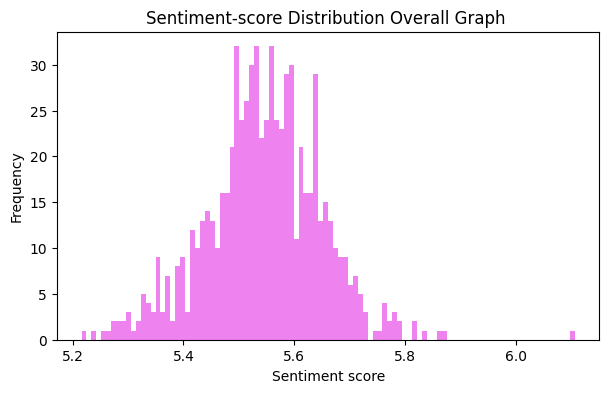

Min sentiment score : 5.216 
Max sentiment score : 6.107


In [103]:
# hist plot Sentiment_score Distibution
plt.figure(figsize=(7,4))
plt.hist(sentiment_list_asc, bins=100, color="violet")
plt.xlabel("Sentiment score")
plt.ylabel("Frequency")
#plt.xlim(4.8, 6.3) # x axis range
plt.title("Sentiment-score Distribution Overall Graph ")
plt.show()
print("Min sentiment score :", round(min(sentiment_list_asc),3), "\nMax sentiment score :", round(max(sentiment_list_asc),3))


**Figure 4.1** <br>

The figure shows the distibution of the sentiment score for the overall graph. The  distibution present a shape similar to a Normal distibution.


In [104]:
# colormap for each Weast- East Coast rapper blue= West, red= East
colormap_sentiment = []  # list of colors for the nodes
for i in character_asc:
    if G.nodes[i]["Coast"] == "West":
        colormap_sentiment.append("blue")
    else:
        colormap_sentiment.append("red")

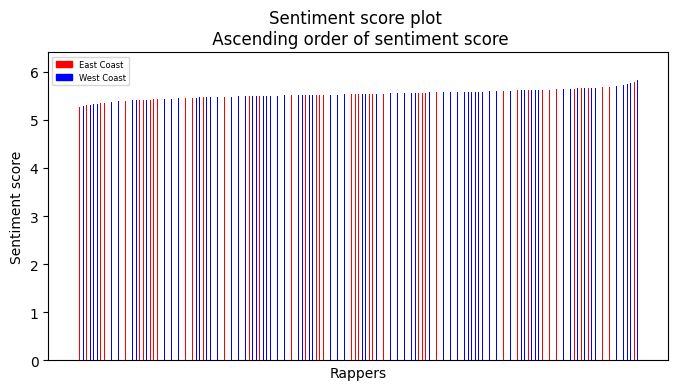

In [105]:
#plot of the sentiment score for each rapper
plt.figure(figsize=(8,4))
plt.bar(character_asc, sentiment_list_asc, color=colormap_sentiment, width=0.2, align='edge')
plt.xlabel("Rappers")
plt.ylabel("Sentiment score")
plt.title("Sentiment score plot \n Ascending order of sentiment score")
plt.xlabel("Rappers")
plt.xticks([])  # remove xticks= rapper names

#Add legends, labels and title to the plot
colors = {'East Coast':'red', 'West Coast':'blue'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0), 1,1,  color=colors[label]) for label in labels ]
plt.legend(handles, labels, fontsize=6,)
plt.show()




**Figure 4.2** <br>

The sentiment score plot of the Graph (composed of the main componenet) shows that the scores appear to be relatively uniformly distributed between the two coasts. To be noticed is the predominance of West coast rappers in our database that tend the blue component to result predominant in the graph.


> * What are the 10 rappers with happiest and saddest pages?

In [106]:
# the 10 most saddest pages according to the sentiment score are:
sadest_10=character_asc[:10]
print("The 10 most saddest pages according to the sentiment score are:\n", sadest_10, "\n")

# the 10 most happiest pages according to the sentiment score are:
happiest_10=character_asc[-10:]
print("The 10 most happiest pages according to the sentiment score are: \n", happiest_10, "\n")

The 10 most saddest pages according to the sentiment score are:
 ["Ol' Dirty Bastard", 'Slip Capone', 'Jimmy Wopo', 'AR-Ab', 'RJ (rapper)', 'Black Rob', 'The Jacka', 'Slow Pain', 'Droop-E', 'Killa Sin'] 

The 10 most happiest pages according to the sentiment score are: 
 ['V-White', 'G-Stack', 'Omega Crosby', 'Emcee N.I.C.E.', 'Dave Free', 'Cool Nutz', 'Mark Batson', 'V. Rose', 'Young Music DYMG', 'Phil Da Agony'] 



Now, compute the sentiment of each coast:
> * Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).


In [148]:
# average sentiment score for each coast
sentiment_score_East = []
sentiment_score_West = []
for i in character_asc:
    if G.nodes[i]["Coast"] == "West":
        # extract sentiment score of i node and append it to the list of West Coast
        if G.nodes[i]["Sentiment_score"] != 0:  # exclude nodes with sentiment score not= 0
            sentiment_score_West.append(G.nodes[i]["Sentiment_score"])
    # same as above for East Coast
    else:
        if G.nodes[i]["Sentiment_score"] != 0:
            sentiment_score_East.append(G.nodes[i]["Sentiment_score"])

# average sentiment score for East Coast
avg_sentiment_East = sum(sentiment_score_East)/len(sentiment_score_East)
# average sentiment score for West Coast
avg_sentiment_West = sum(sentiment_score_West)/len(sentiment_score_West)

print("Average sentiment score for East Coast :", round(avg_sentiment_East,4), "\n")
print("Average sentiment score for West Coast :", round(avg_sentiment_West,4), "\n")
print("It could be seen that the average sentiment score for East Coast is slightly higher than the West Coast. However the difference is really smalll.  \n")

Average sentiment score for East Coast : 5.5497 

Average sentiment score for West Coast : 5.5408 

It could be seen that the average sentiment score for East Coast is slightly higher than the West Coast. However the difference is really smalll.  



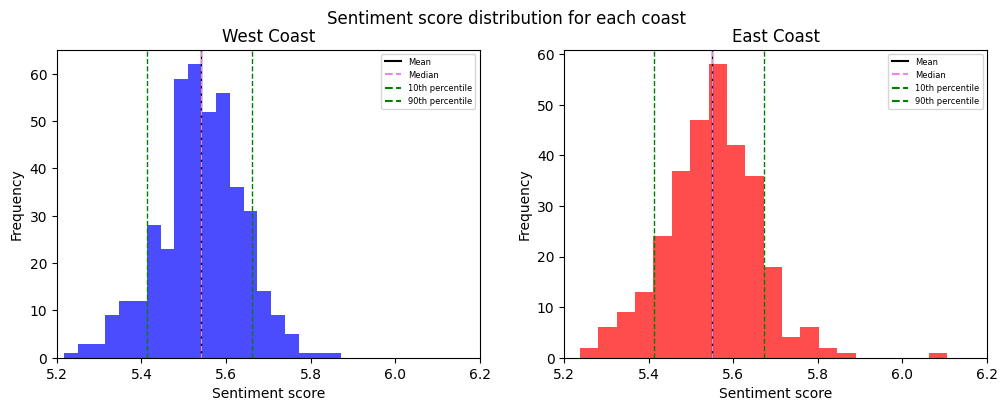

In [109]:
# Subplot comparing  West Coast against East Coast score distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# figure titile
fig.suptitle('Sentiment score distribution for each coast')

# Create histograms for each coast's sentiment
hist_west = ax1.hist(sentiment_score_West, bins=20, color='blue', alpha=0.7, label='West Coast')
hist_east = ax2.hist(sentiment_score_East, bins=20, color='red', alpha=0.7, label='East Coast')
# ax1 x range
ax1.set_xlim(5.2, 6.2)
# ax2 x range
ax2.set_xlim(5.2, 6.2)

mean_west = np.mean(sentiment_score_West)
mean_east = np.mean(sentiment_score_East)
median_west = np.median(sentiment_score_West)
median_east = np.median(sentiment_score_East)
percentile_10_west = np.percentile(sentiment_score_West, 10)
percentile_10_east = np.percentile(sentiment_score_East, 10)
percentile_90_west = np.percentile(sentiment_score_West, 90)
percentile_90_east = np.percentile(sentiment_score_East, 90)

# Add vertical lines for the statistics
ax1.axvline(mean_west, color='black', linestyle='solid', linewidth=1)
ax1.axvline(median_west, color='violet', linestyle='dashed', linewidth=1)
ax1.axvline(percentile_10_west, color='green', linestyle='dashed', linewidth=1)
ax1.axvline(percentile_90_west, color='green', linestyle='dashed', linewidth=1)

ax2.axvline(mean_east, color='black', linestyle='solid', linewidth=1, label='Dashed lines')
ax2.axvline(median_east, color='violet', linestyle='dashed', linewidth=1)
ax2.axvline(percentile_10_east, color='green', linestyle='dashed', linewidth=1)
ax2.axvline(percentile_90_east, color='green', linestyle='dashed', linewidth=1)

# Add legends, labels and title to the plot
ax1.set_xlabel('Sentiment score')
ax1.set_ylabel('Frequency')
ax1.set_title('West Coast')
ax1.legend()

ax2.set_xlabel('Sentiment score')
ax2.set_ylabel('Frequency')
ax2.set_title('East Coast')
ax2.legend()


#Add legends, labels and title to the plot
colors = {"Mean":'black', "Median":'violet', "10th percentile":'green', "90th percentile":'green'}
labels = list(colors.keys())
handles = [plt.Line2D([0], [0], color=colors[label], linestyle='-' if label == "Mean" else '--') for label in labels]
ax1.legend(handles, labels, fontsize=6,)
ax2.legend(handles, labels, fontsize=6,)

plt.show()


**Figure 4.3** <br>

The plot above demonstrates that not only does the sentiment score mean from the East  seem very similar to the one of the West Coast, but so do the overall distributions. Furthermore, it was observed that the two distributions differ primarily for the outliers.Indeed, high score outliers characterize the East coast distribution, by contrast no outlier are found in the West coast Distibution..

> * Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.


In [46]:
import random
import scipy.stats as stats

In [47]:
def permutation_attibute(G, attribute_name="Coast"):

    G_copy = G.copy()  # just to be sure to not change the original graph (maybe not needed!!)
    # Shuffle the node attribute values
    nodes = list(G_copy.nodes())  # list of nodes
    random.shuffle(nodes)  # Shuffle the order of nodes ()
    attribute_list = [G_copy.nodes[node][attribute_name] for node in nodes]  # List of attribute values
    random.shuffle(attribute_list) # the important part!!!

    # Reassign shuffled attributes
    shuffled_attributes = {node: attribute_list[i] for i , node in enumerate(nodes)}
    nx.set_node_attributes(G_copy, shuffled_attributes, attribute_name)
    return G_copy

In [48]:
# Function to calculate the average sentiment score of a graph
def avg_sentiment_score_east(G):
    # remove nodes with sentiment score = 0
    list_score = [ G.nodes[i]["Sentiment_score"]  for i in G.nodes if G.nodes[i]["Sentiment_score"] != 0 and G.nodes[i]["Coast"]  == "East" ]

    return sum(list_score)/len(list_score)  # return the average sentiment score

 The sub graph is then used to compute the average sentiment score. This process is repeated 1000 times and the average sentiment score is stored in a list.

In [49]:
# The East Coast has  a slightly higher average sentiment score than the West Coast
n_nodes = len([i for i in G.nodes() if G.nodes[i]["Coast"] == "East"])  # number of nodes in the East Coast

avg_scores_East_permuted=[]  #
for i in range(0,1000):
    G_random_subgraph = permutation_attibute(G)  # extract a random subgraph with the same number of nodes as the East Coast
    #avg_= 5 # compute the average sentiment score of the random subgraph
    avg_ = avg_sentiment_score_east(G_random_subgraph)
    if avg_ != 0:  # exclude subgraphs with average sentiment score = 0
        avg_scores_East_permuted.append(avg_)


 **PERFORME ONE SAMPLE Student T-test**

 To test that the *average east sentiment score*
This is a test for the null hypothesis that the expected value $\mu$  of a sample of independent observations ( random generated graphs average sentiment score)  is equal to the given population mean $\mu_0$ (= Aveerage sentiment score East).

**Test Hypotehsis:**

 $H_0 :\mu =\mu_0 $

  $H :\mu < \mu_0 $

 Where
 * $\mu$ is the calculated mean of the population
 * $\mu_0$ is the hypotized mean(= Average sentiment score East)

 * *t represents the t-statistic* further information could be found here: [ One-sample t-test](https://bookdown.org/joao_msoutomaior/intro-stats-notes/one-sample-t-test-1.html)

 $t = \frac{{\bar{X} - \mu_0}}{{s / \sqrt{n}}}$

 With:
 * $\bar{X}$ the mean of the (= random generated graphs average sentiment score)
 * $\mu_0$ (= Aveerage sentiment score East)
 * *s*  ( standard deviation of the sample)
 * n (= sample dimension)



ref: [scipy.stats.ttest_1samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html)




Preliminary: to peform the student t-test, the distribution of the data has to be normal.
Check if the distribution of the data is normal with the Shapiro-Wilk test.

In [50]:
statistic, p_value = stats.shapiro(avg_scores_East_permuted)
if p_value < 0.05:
    print("The distribution is not normal")
else:
    print("The distribution is normal")

The distribution is normal


One sided Student t-test is perfomed to test the hypothesis that the average sentiment score of the East Coast is higher than the average sentiment score of the permutedsample. The alternative hypothesis is that the average sentiment score of the East Coast is higher than the average sentiment score of random groups.

In [51]:
# one sided t-test :  "the mean of the underlying distribution of the sample is less than the given population mean (popmean)"
test= stats.ttest_1samp(avg_scores_East_permuted, popmean= avg_sentiment_East , alternative='less')
print("p-value :", test.pvalue, "\n")
if test.pvalue < 0.05:
    print("The null hypothesis is not accepted. \n")
else:
    print("The null hypothesis is accepted. \n")


p-value : 2.9621231620858632e-164 

The null hypothesis is not accepted. 



The Stident T-test shows that the average sentiment score of the East Coast is significantly higher than the average sentiment score of the West Coast with a significance level of 0.05.

:> * Does the result make sense to you? Elaborate.



Firstly is important to clarify that a T-test don't answer the question if the $\mu_0$ given mean could be extracted from the Distibution of the average of the sample. In fact as could be seen in the figure below **Figure 4.4**<br>, the *average sentiment score of the East coast group* $\mu_0$ is clearly below the 95% percentile trashold of the *average sentiment score Distibution* of the randomly generated groups.In other words, is not to strange to find a $\mu_0$ value coming from the randomly generated distibution.

Indeed, the T-test compares the given  $\mu_0$ to the extracted $\mu$ (= $\bar{x}$)from the sample. It calculate the t statistic given $\mu_0$ and state if the sample distibution could be generated from a distibution with the mean $\mu$ =  $\mu_0$ with 95% confidence. In other words, with a confidence of 95%,( 95 times out of 100) the average of the sample distibutions  would fall inside the confidence interval
($\bar{x} -  t_{{\alpha}, n-1} \frac{s}{\sqrt{n}}$ ; +$\infty$ ). If this condition is not reached by the given $\mu_0$, the Null hypothesis $\mu$ =  $\mu_0$ could not be accepted. **Figure 4.5**


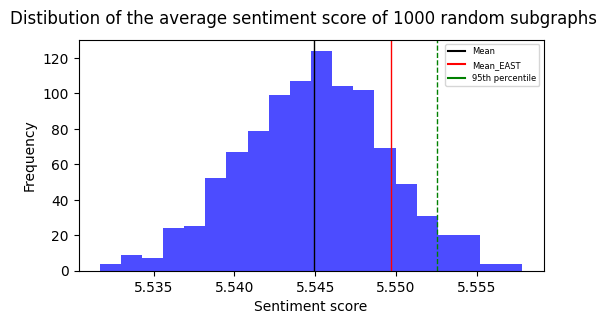

In [68]:
# Create a figure with subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 3))
# figure titile
fig.suptitle('Distibution of the average sentiment score of 1000 random subgraphs')

# Create histograms for each coast's sentiment
hist_west = ax1.hist(avg_scores_East_permuted, bins=20, color='blue', alpha=0.7, label='West Coast')
hist_east = ax2.hist(sentiment_score_East, bins=20, color='red', alpha=0.7, label='East Coast')
# ax1 x range
#ax1.set_xlim(4.8, 6.3)
# ax2 x range
ax2.set_xlim(4.8, 6.3)

mean_r = np.mean(avg_scores_East_permuted)
mean_east = np.mean(sentiment_score_East)

median_r = np.median(avg_scores_East_permuted)
#percentile_5_r = np.percentile(avg_scores_East_permuted, 2.5)
percentile_95_r = np.percentile(avg_scores_East_permuted, 95)


# Add vertical lines for the statistics
ax1.axvline(mean_r, color='black', linestyle='solid', linewidth=1)
ax1.axvline(mean_east, color='red', linestyle='solid', linewidth=1)
#ax1.axvline(percentile_5_r, color='green', linestyle='dashed', linewidth=1)
ax1.axvline(percentile_95_r, color='green', linestyle='dashed', linewidth=1)

# Add legends, labels and title to the plot
ax1.set_xlabel('Sentiment score')
ax1.set_ylabel('Frequency')





#Add legends, labels and title to the plot
colors = {"Mean":'black', "Mean_EAST":'red', "95th percentile":'green'}
labels = list(colors.keys())
handles = [plt.Line2D([0], [0], color=colors[label], linestyle='-' if label == "Mean" or "Mean_EAST" else '--') for label in labels]
ax1.legend(handles, labels, fontsize=6,)
plt.show()


**Figure 4.4** <br>
The figure shows the distribution of sentiment scores coming from the 1000 random Graphs; its mean and the 95 percentile. In red, the mean of the West Coast is shown. It could be noticed that the West Coast sentiment score appears to be under the 95% percentile. However, this only demonstrates that the $\mu_0$ value could come from a random distibution but not what we want: that the found random distibution mean could come from the $\mu_0$ parameter.

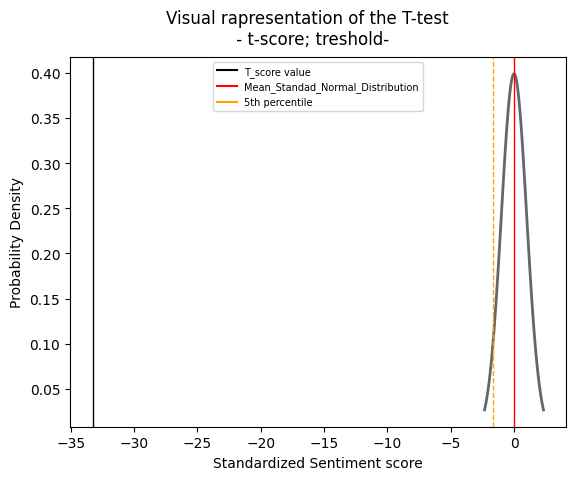

In [75]:
x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100) # range ( , ) with 100 points
fig, ax = plt.subplots(1, 1)
ax.plot(x, norm.pdf(x), 'k-', lw=2, alpha=0.6, label='norm pdf') # plot the standard normal distribution

fig.suptitle('Visual rapresentation of the T-test ')
# set 5% percentile (sigificance level) and plot it
percentile_5_pdf = norm.ppf(0.05)
ax.axvline(percentile_5_pdf, color='orange', linestyle='dashed', linewidth=1)
n= len(avg_scores_East_permuted)-1  # degree fredom

ax.axvline(0, color='red', linestyle='-', linewidth=1)
t_score  = (np.mean(avg_scores_East_permuted) - mean_east) / (np.std(avg_scores_East_permuted)/math.sqrt(n)   ) # standardize the random average sentiment score
ax.axvline(t_score, color='black', linestyle='-', linewidth=1)
ax.set_ylabel('Probability Density')
ax.set_xlabel('Standardized Sentiment score')

#Add legends, labels and title to the plot
colors = {"T_score value":'black', "Mean_Standad_Normal_Distribution":'red', "5th percentile":'orange'}
labels = list(colors.keys())
handles = [plt.Line2D([0], [0], color=colors[label], linestyle='-' if label == "T_score value" or "Mean_Standad_Normal_Distribution" else '--') for label in labels]
ax.legend(handles, labels, fontsize=7,  loc='upper center')

plt.show()

**Figure 4.5** <br>
In the figure, the visual outcome of the T-test is shownn.It could be seen that the t_score value (the normalized value of the sample mean for a student T distribution) falls before the confidence threshold of 5%. The Null hypotheiss coudl not be accepted.

**References:**

@Dodds, P. S., Harris, K. D., Kloumann, I. M., Bliss, C. A., & Danforth, C. M. Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter. PLOS ONE, 6(12), e26752. [https://doi.org/10.1371/journal.pone.0026752]


@online{scipy-ttest1samp,
  title = {scipy.stats.ttest\_1samp},
  url = {https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html},
  organization = {SciPy.org},
  note = {Accessed on: [Insert the date you accessed the page]},
}


@online{souto-maior-notes,
  author = {Joao M. Souto-Maior},
  title = {Notes for Basic Statistics I},
  year = {2021},
  organization = {New York University (NYU)},
  note = {Spring 2021},
  url= [https://bookdown.org/joao_msoutomaior/intro-stats-notes/one-sample-t-test-1.html]
}




